# T2_feature_eng_test

In [1]:
# general tools
import sys
from glob import glob
from os.path import basename
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np

# stats tools
import scipy.optimize
from scipy.signal import periodogram

# graph tools
import matplotlib.pyplot as plt
%matplotlib inline

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
import data_utils as du
from namelist import * 

# pre-engineered samples

**Selecting variables and time**

In [58]:
VAR = 'TMEAN'
# dt list for all
N_all = 365 + 366 + 365 + 365 + 365
all_list = [datetime(2015, 1, 1, 0) + timedelta(days=x) for x in range(N_all)]
# dt list for pred, 2018-2020
N_train = 365 + 366 + 365
train_list = [datetime(2015, 1, 1, 0) + timedelta(days=x) for x in range(N_train)]
# indices
ind_train = du.dt_match(all_list, train_list)
ind_train_sea = du.season_ind_sep(train_list, key_format='{}')

In [3]:
with h5py.File(PRISM_dir+'PRISM_regrid_2015_2020.hdf', 'r') as hdf_io:
    T_4km = hdf_io['{}_4km'.format(VAR)][ind_train, ...]
    T_025 = hdf_io['{}_025'.format(VAR)][ind_train, ...]
    #T_REGRID = hdf_io['{}_REGRID'.format(VAR)][ind_train, ...]
    #land_mask = hdf_io['land_mask'][...]

In [59]:
with h5py.File(PRISM_dir+'PRISM_{}_features_2015_2020.hdf'.format(VAR), 'r') as hdf_io:
    T_engineered = hdf_io['{}_4km'.format(VAR)][...]
    R_engineered = hdf_io['{}_REGRID'.format(VAR)][...]

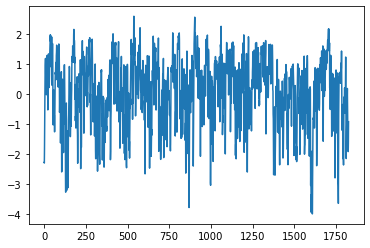

In [61]:
plt.plot(T_engineered[:, 300, 300])

**Plot annual signals**

In [5]:
t_365 = np.linspace(0, 2*np.pi, 365)
t_366 = np.linspace(0, 2*np.pi, 366)
t_cyclic = np.concatenate((t_365, t_366, t_365), axis=0)

**Try sine fit?**

In [6]:
def sinfunc_annual(t, A, p, c):
    return A * np.sin(t + p) + c

def fit_sin_annual(t, y):
    
    # initial guess
    w0 = 1.0 # <--- one year
    amp0 = np.std(y) * 2.**0.5
    offset0 = np.mean(y)
    guess = np.array([amp0, 0, offset0])
    
    # OLS fit
    param, _ = scipy.optimize.curve_fit(sinfunc_annual, t, y, p0=guess, maxfev=100000000)
    return param

In [7]:
shape_025 = T_025.shape
shape_4km = T_4km.shape

In [11]:
T_sine = np.zeros(shape_025)

for i in range(shape_025[1]):
    for j in range(shape_025[2]):
        A, p, c = fit_sin_annual(t_cyclic, T_025[:, i, j])
        T_sine[:, i, j] = sinfunc_annual(t_cyclic, A, p, c)

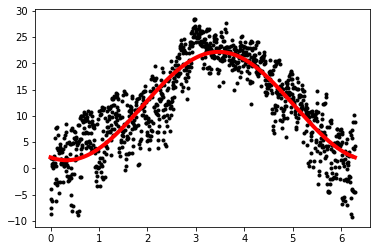

In [12]:
plt.plot(t_cyclic[:], T_025[:, 50, 50], 'k.')
plt.plot(t_cyclic[:365], T_sine[:365, 50, 50], 'r-', lw=4)

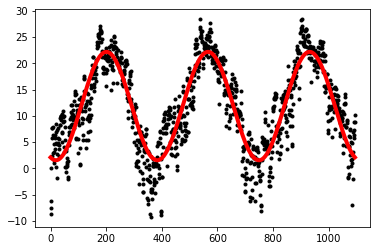

In [15]:
plt.plot(T_025[:, 50, 50], 'k.')
plt.plot(T_sine[:, 50, 50], 'r-', lw=4)

* stddev changes over time

**calculating stddev by month**

In [16]:
days_365 = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
days_366 = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
cumsum_365 = np.cumsum(np.array([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]))
cumsum_366 = np.cumsum(np.array([0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]))

t_midmon365 = np.zeros(12)
t_midmon366 = np.zeros(12)
for i in range(12):
    ceil_365 = np.ceil(0.5*days_365[i])
    ceil_366 = np.ceil(0.5*days_366[i])
    floor_365 = np.floor(0.5*days_365[i])
    floor_366 = np.floor(0.5*days_366[i])
    t_midmon365[i] = 0.5*(t_365[int(cumsum_365[i]+floor_365)] + t_365[int(cumsum_365[i]+ceil_365)])
    t_midmon366[i] = 0.5*(t_366[int(cumsum_366[i]+floor_366)] + t_366[int(cumsum_366[i]+ceil_366)])

t_midmon = (2/3)*(t_midmon365) + (1/3)*(t_midmon366)
month_sep = np.zeros([12, 31*3])*np.nan # *3 for 3 year, 2015-2018


In [17]:
STD_sine = np.zeros(shape_025)*np.nan

diff_T = T_025 - T_sine

for i in range(shape_025[1]):
    for j in range(shape_025[2]):
        count = [0]*12
        temp_grid_point = diff_T[:, i, j]
        for k, date in enumerate(train_list):
            mon_ind = date.month - 1
            month_sep[mon_ind, count[mon_ind]] = temp_grid_point[k]
            count[mon_ind] += 1

        A, p, c = fit_sin_annual(t_midmon, np.nanstd(month_sep, axis=1))
        STD_sine[:, i, j] = sinfunc_annual(t_cyclic, A, p, c)

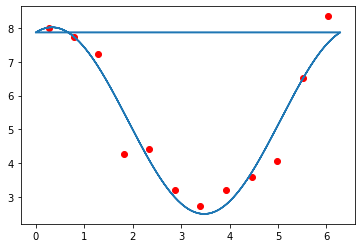

In [21]:
plt.plot(t_midmon, np.nanstd(month_sep, axis=1), 'ro')
plt.plot(t_cyclic, STD_sine[:, i, j])

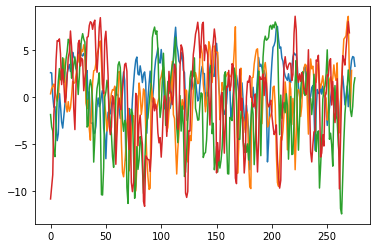

In [76]:
plt.plot(diff_T[ind_train_sea['jja'], 50, 50])
plt.plot(diff_T[ind_train_sea['son'], 50, 50])
plt.plot(diff_T[ind_train_sea['mam'], 50, 50])
plt.plot(diff_T[ind_train_sea['djf'], 50, 50])
#plt.plot(10*diff_T[:, 50, 50]/(STD_sine[:, 50, 50]**3), 'r-')

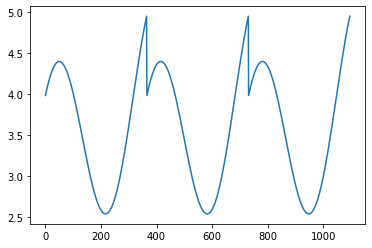

In [65]:
np.nanmax(T_engineered[180, ...])

7.531745030962358

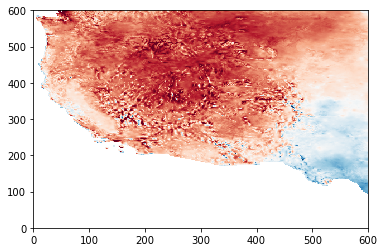

In [62]:

plt.pcolormesh(T_engineered[180, ...], vmin=-3, vmax=3, cmap=plt.cm.RdBu_r)

In [56]:
np.nanstd(T_engineered[180, ...])

0.9448235468028197

In [57]:
np.nanstd(R_engineered[180, ...])

0.880103969093442

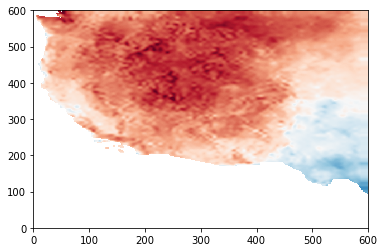

In [63]:
plt.pcolormesh(R_engineered[180, ...], vmin=-3, vmax=3, cmap=plt.cm.RdBu_r)

(array([  58.,  457., 1125., 2135., 1525.,  935.,  786.,  903., 1970.,
           6.]),
 array([ 1.16378573,  4.11798165,  7.07217757, 10.02637349, 12.98056941,
        15.93476533, 18.88896125, 21.84315717, 24.79735308, 27.751549  ,
        30.70574492]),
 <a list of 10 Patch objects>)

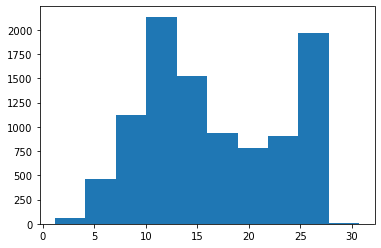

In [90]:
plt.hist(T_sine[180, ...].ravel())